In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
import numpy as np 

data_path = r'D:\dataset\kagglecatsanddogs_5340\PetImages'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
## load dataset 
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'training',
    image_size = image_size,
    batch_size = batch_size,
    seed = 1337,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'validation',
    image_size = image_size,
    batch_size = batch_size,
    seed = 1337,
)

Num GPUs Available:  1
Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [ ]:
# ## delete unsupported image files.

# import os

# num_skipped = 0

# for folder_name in ('Cat', 'Dog'):
#     folder_path = os.path.join(data_path, folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, 'rb')
#             is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # delete corrupted images
#             os.remove(fpath)


In [ ]:

## visualize data samples
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')
    plt.show()


In [14]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1)
    ]
)

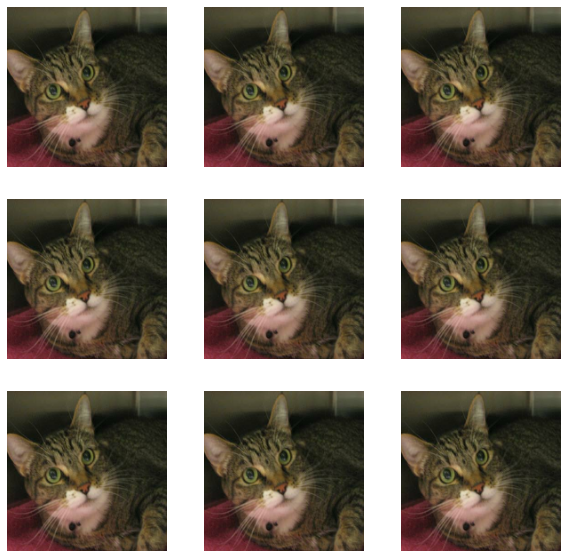

In [15]:
# visualize data augmentation
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [28]:
# prefetch data for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

(32,)


In [20]:
# build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides = 2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides = 2, padding='same')(
            previous_block_activation
        )

        # add back residual
        x = layers.add([x, residual])
        previous_block_activation = x


    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
    


In [21]:
# compile a model

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [22]:
# train the model

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.BinaryAccuracy()],
)
model.summary()

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_5[0][0]']                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[2][0]']           
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_4[0][0]']        

In [24]:
# run inference on new data

image = keras.preprocessing.image.load_img(
    f"{data_path}/Cat/6779.jpg", target_size = image_size
)

img_array = keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0) # create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    'This image is %.2f percent cat and %.2f percent dog.' 
    % (100 * (1 - score), 100 * score)
)


1/1 [==============================] - 0s 21ms/step
This image is 99.96 percent cat and 0.04 percent dog.
